In [1]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF

# Define some convenient functions to plot model results

In [2]:
def make_meshgrid(x, y, h=.02):
    """Create a mesh of points to plot in

    Parameters
    ----------
    x: data to base x-axis meshgrid on
    y: data to base y-axis meshgrid on
    h: stepsize for meshgrid, optional

    Returns
    -------
    xx, yy : ndarray
    """
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy

In [3]:
def plot_contours(ax, clf, xx, yy, **params):
    """Plot the decision boundaries for a classifier.

    Parameters
    ----------
    ax: matplotlib axes object
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: dictionary of params to pass to contourf, optional
    """
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

In [4]:
def iris_classifier(df, independant_var, title, model):
    """Fit a classifer defined in model based on independant_var

    Parameters
    ----------
    df: dataset
    independant_var: list of independant variable (length 2)
    model: sklearn classifier
    """
    
    model.fit(df[independant_var], df['target'])
    X0, X1 = df[independant_var[0]], df[independant_var[1]]
    xx, yy = make_meshgrid(X0, X1)
    y=df['target']
    
    fig, ax = plt.subplots(1, 1)
    plot_contours(ax, model, xx, yy,
                  cmap=plt.cm.coolwarm, alpha=0.8)
    ax.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xlabel(independant_var[0])
    ax.set_ylabel(independant_var[1])
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(title)

# Import data

In [5]:
# import some data to play with
iris = datasets.load_iris()

In [6]:
print(iris.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

In [7]:
print(iris.feature_names)

['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']


In [8]:
df = pd.DataFrame(data=iris.data, columns=iris.feature_names)
df['target'] = iris.target
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


# Define and analyse classification models

In [9]:
models = {
    'linear SVC': LinearSVC(C=1, max_iter=10000),
    'SVC with linear kernel': SVC(kernel='linear', C=1),
    'SVC with polynomial kernel': SVC(kernel='poly', degree=3, gamma='auto', C=1),
    'SVC with rbf kernel': SVC(kernel='rbf', gamma=0.7, C=1),
    'KNN uniform weight': KNeighborsClassifier(20, weights='uniform'),
    'KNN distance weight': KNeighborsClassifier(20, weights='distance'),
    'decision tree depth 1': DecisionTreeClassifier(max_depth=1, min_samples_split=4, min_samples_leaf=4),
    'decision tree depth 2': DecisionTreeClassifier(max_depth=2, min_samples_split=4, min_samples_leaf=4),
    'decision tree depth 3': DecisionTreeClassifier(max_depth=3, min_samples_split=4, min_samples_leaf=4),
    'gaussian process': GaussianProcessClassifier(kernel=RBF())   
}

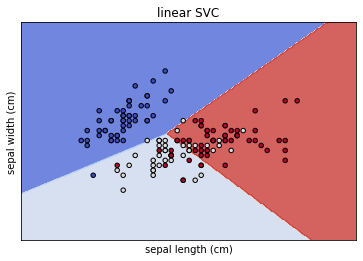

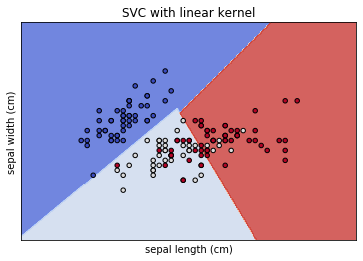

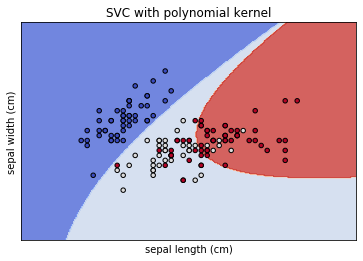

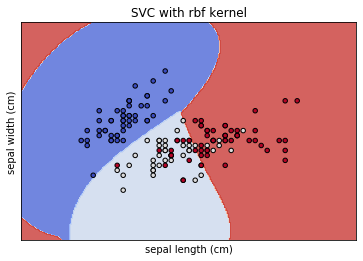

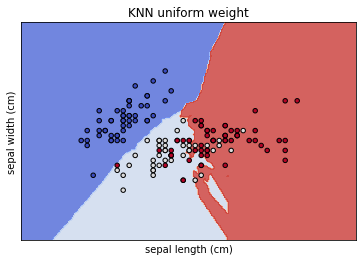

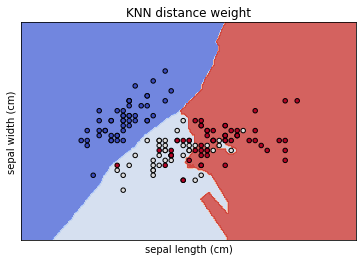

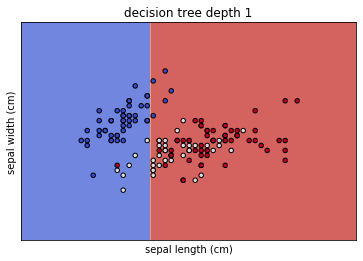

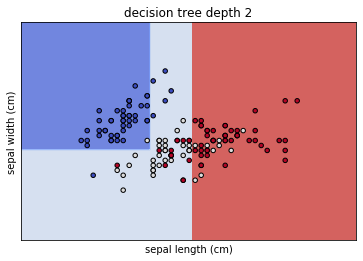

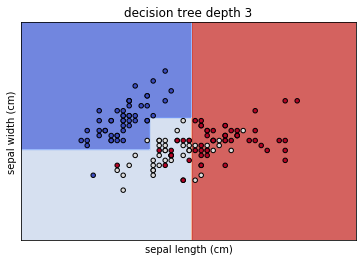

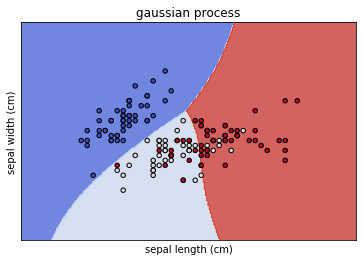

In [10]:
independant_var = ['sepal length (cm)', 'sepal width (cm)']

for key, item in models.items():
    iris_classifier(df, independant_var, key, item)

# Clustering

In [11]:
from sklearn.cluster import KMeans
independant_var = ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
k_means = KMeans(n_clusters=3)
k_means.fit(df[independant_var])

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

Text(0.5, 1.0, 'cluster')

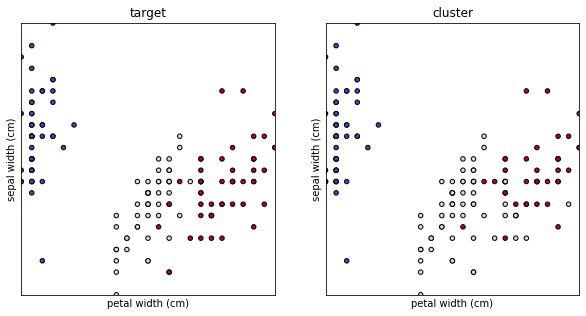

In [12]:
randomlist = random.sample(range(0, len(independant_var)), len(independant_var))
independant_var2 = []
for i in randomlist:
    independant_var2.append(independant_var[i])

df['cluster'] = k_means.labels_
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].scatter(df[independant_var2[0]], df[independant_var2[1]], c=df['target'], cmap=plt.cm.coolwarm, s=20, edgecolors='k')
ax[0].set_xlim(df[independant_var2[0]].min(), df[independant_var2[0]].max())
ax[0].set_ylim(df[independant_var2[1]].min(), df[independant_var2[1]].max())
ax[0].set_xlabel(independant_var2[0])
ax[0].set_ylabel(independant_var2[1])
ax[0].set_xticks(())
ax[0].set_yticks(())
ax[0].set_title('target')

ax[1].scatter(df[independant_var2[0]], df[independant_var2[1]], c=df['cluster'], cmap=plt.cm.coolwarm, s=20, edgecolors='k')
ax[1].set_xlim(df[independant_var2[0]].min(), df[independant_var2[0]].max())
ax[1].set_ylim(df[independant_var2[1]].min(), df[independant_var2[1]].max())
ax[1].set_xlabel(independant_var2[0])
ax[1].set_ylabel(independant_var2[1])
ax[1].set_xticks(())
ax[1].set_yticks(())
ax[1].set_title('cluster')

https://www.groupe-hli.com/machine-learning-dans-industrie/